In [1]:
import os
import pickle

from reclist.datasets import CoveoDataset
from reclist.recommenders.prod2vec import CoveoP2VRecModel
from reclist.reclist import CoveoCartRecList

from oodles import Framework, monitor, Anomaly, BiasAlgo
import collections

In [2]:
coveo_dataset = CoveoDataset()

In [3]:
if not os.path.exists('model_shopping_cart.pickle'):
    model = CoveoP2VRecModel()
    model.train(coveo_dataset.x_train)
    with open('model_shopping_cart.pickle', 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('model_shopping_cart.pickle', 'rb') as handle:
        model = pickle.load(handle)

In [4]:
rec_list = CoveoCartRecList(
    model=model,
    dataset=coveo_dataset
)

In [5]:
x_train = coveo_dataset._x_train
x_train_sku = rec_list.sku_only(x_train)

In [6]:
# estimate popularity from training data
pop_map = collections.defaultdict(lambda : 0)
num_interactions = 0
for session in x_train_sku:
    for event in session:
        pop_map[event] += 1
        num_interactions += 1

# normalize popularity
pop_map = {k:v/num_interactions for k,v in pop_map.items()}

In [7]:
x_test = rec_list._x_test
y_test = rec_list._y_test

In [8]:
inference_batch_size = len(x_test)
cfg = {
    # Define your metrics to identify data drifts
    "checks": [
        {
        'type': Anomaly.POPULARITY_BIAS,
        'algorithm': BiasAlgo.POPULARITY_BIAS,
        'rec_list': rec_list,
        'pop_map': pop_map,    
        },
    ], 
    "batch_size": inference_batch_size,
    "training_args": {
        "fold_name": 'oodles_smart_data', 
        "log_folder": "oodles_logs",
    }
}

framework = Framework(cfg)

@monitor(framework)
def model_predict(model, inputs):
    return model.predict(inputs['data'])

Deleting the folder:  oodles_smart_data


In [ ]:
for i in range(int(len(x_test)/inference_batch_size)):
    inputs = {'data': x_test[i*inference_batch_size:(i+1)*inference_batch_size]}
    
    y_pred, ids = model_predict(model, inputs)
    framework.attach_ground_truth({'id': ids, 
                                   'gt': y_test[i*inference_batch_size:(i+1)*inference_batch_size]})

### Histogram plot for items with popularity

From the below plot, we can see that most of the items that are recommended have low popularity (<0.0002). Thus, our model does not look to be suffering from popularity bias.

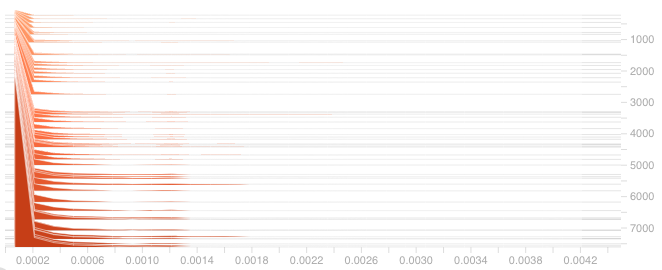